## Step 2: Data Cleaning & Handling Inconsistencies

### 2.1 Load the Dataset

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype 


df = pd.read_csv("tracks.csv", low_memory=False)


# Quick check of data
print(df.shape)
df.head()


(899702, 33)


,track_id,streams,artist_followers,genres,album_total_tracks,track_artists,artist_popularity,explicit,tempo,chart,...,speechiness,region,danceability,valence,acousticness,liveness,trend,instrumentalness,loudness,name
0,07vS8obfeZbr8H4MgQfXR7,NaN,2338837.0,"['indie pop', 'la indie', 'pov: indie']",2.0,Phoebe Bridgers,74.0,False,97.129,NaN,...,0.0407,NaN,0.373,0.138,0.9480,0.0816,NaN,0.000000,-15.193,Friday I’m In Love - Recorded at Spotify Studi...
1,1PEqh7awkpuepLBSq8ZwqD,27156.0,84914.0,"['lilith', 'new wave pop']",11.0,NaN,51.0,False,103.773,top200,...,0.0348,France,0.744,0.122,0.6270,0.0898,NEW_ENTRY,0.421000,-11.977,I Love You Always Forever
2,7E8pPgBY84oDaXRcqODavR,NaN,59150.0,"['deep groove house', 'house', 'tech house']",2.0,NaN,54.0,False,122.030,NaN,...,0.0357,NaN,0.747,0.897,0.0794,0.3700,NaN,0.000531,-5.209,Love Too Deep - Radio Edit
3,0Atml4huw4Fgyk6YSHiK4M,NaN,1528.0,[],15.0,NaN,0.0,False,84.099,NaN,...,0.0356,NaN,0.604,0.564,0.1000,0.0865,NaN,0.000000,-7.097,No Tiren Las Botellas
4,4WYDmIZrwxBHdBYdvi5oQO,NaN,6776.0,"['chill lounge', 'deep chill']",26.0,NaN,28.0,False,156.017,NaN,...,0.0613,NaN,0.761,0.761,0.0616,0.0822,NaN,0.873000,-10.961,El Momento de Despertar - Blue Sky Mix


### 2.2 Remove Duplicate Rows

In [2]:
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"Removed {initial_shape[0] - df.shape[0]} duplicate rows.")


Removed 0 duplicate rows.


### 2.3 Check & Fix Incorrect Data Formats

In this step, we'll:
1. Check the current dtypes to see which columns need converting.
2. Convert certain columns to numeric, datetime, or boolean.
3. Parse string representations of lists into actual Python lists (e.g., genres, available_markets).
4. Standardize string columns (removing extraneous spaces, lowercasing if needed).

In [3]:
# 2.3.1 Check current data types
print("Data types before any conversions:")
print(df.dtypes)
print("\nSample Rows:")
print(df.head(3))


Data types before any conversions:
track_id               object
streams               float64
artist_followers      float64
genres                 object
album_total_tracks    float64
track_artists          object
artist_popularity     float64
explicit               object
tempo                 float64
chart                  object
album_release_date     object
energy                float64
key                   float64
added_at               object
popularity            float64
track_album_album      object
duration_ms           float64
available_markets      object
track_track_number    float64
rank                  float64
mode                  float64
time_signature        float64
album_name             object
speechiness           float64
region                 object
danceability          float64
valence               float64
acousticness          float64
liveness              float64
trend                  object
instrumentalness      float64
loudness              float64
name 

In [4]:
# 2.3.2 Convert columns to numeric
numeric_cols = [
    "streams", 
    "artist_followers", 
    "album_total_tracks", 
    "artist_popularity", 
    "tempo", 
    "energy", 
    "key", 
    "popularity", 
    "duration_ms", 
    "track_track_number", 
    "rank", 
    "mode", 
    "time_signature", 
    "speechiness", 
    "danceability", 
    "valence", 
    "acousticness", 
    "liveness", 
    "instrumentalness", 
    "loudness"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        

In [5]:
# 2.3.3 Convert columns to Datetime
# Some columns, like "album_release_date" or "added_at" should be dates but appear as strings

date_cols = ["album_release_date", "added_at"]

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)


In [6]:
# 2.3.4 Convert Columns to Boolean or Categorical 
# A) Convert to Boolean
if "explicit" in df.columns:
    # Convert to uppercase strings first
    df["explicit"] = df["explicit"].astype(str).str.upper()
    # Map string values to booleans
    df["explicit"] = df["explicit"].replace({"FALSE": False, "TRUE": True})
    df["explicit"] = df["explicit"].astype(bool)


In [7]:
# B) Convert to Categorical
cat_candidates = [
    "chart", 
    "region", 
    "track_album_album", 
    "album_name", 
    "trend", 
    "track_artists"
]

for col in cat_candidates:
    if col in df.columns:
        df[col] = df[col].astype("category")

In [8]:
# 2.3.5 Parse List-Like Columns
import ast

def parse_list_if_string(x):
    """
    Try converting string-list (e.g. "['rock', 'pop']") to a Python list.
    Otherwise return empty list or the original value if it's already a list.
    """
    if isinstance(x, list):
        return x  # Already a list
    if isinstance(x, str) and x.strip().startswith("[") and x.strip().endswith("]"):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

list_like_cols = ["genres", "available_markets"]

for col in list_like_cols:
    if col in df.columns:
        df[col] = df[col].apply(parse_list_if_string)


In [9]:
# 2.3.6 Check Data Types Again
print("\nData types AFTER numeric/datetime/boolean conversions:")
print(df.dtypes)



Data types AFTER numeric/datetime/boolean conversions:
track_id                           object
streams                           float64
artist_followers                  float64
genres                             object
album_total_tracks                float64
track_artists                    category
artist_popularity                 float64
explicit                             bool
tempo                             float64
chart                            category
album_release_date         datetime64[ns]
energy                            float64
key                               float64
added_at              datetime64[ns, UTC]
popularity                        float64
track_album_album                category
duration_ms                       float64
available_markets                  object
track_track_number                float64
rank                              float64
mode                              float64
time_signature                    float64
album_name          

### 2.4 Standardize Inconsistent String Labels

In [10]:
if "chart" in df.columns:
    # Lowercase and strip whitespace
    df["chart"] = df["chart"].astype(str).str.lower().str.strip()
    # Replace synonyms
    df["chart"] = df["chart"].replace({
        "top 200": "top200",
        "top_200": "top200"
    })

### 2.5 Handle Missing Values

In [ ]:
# Some columns may still have NaN after type conversion. We will decide how to fill or drop them.
# Numeric columns can be imputed with mean or median.
# Categorical columns can be imputed with mode or a placeholder like "unknown".

# 2.5.1 Check Missing Counts BEFORE Imputation
print("\nMissing Values by Column (Before Imputation):")
print(df.isnull().sum().sort_values(ascending=False))

# 2.5.2 Impute Numeric Columns with Median
numeric_cols_to_fill = [
    "streams",
    "tempo",
    "danceability",
    "valence",
    "duration_ms",
    "rank",
    "artist_followers",
    "artist_popularity",
    "energy",
    "mode",
    "loudness",
    "instrumentalness",
    "liveness",
    "acousticness",
    "speechiness",
    "key",
    "time_signature",
    "popularity",
    "album_total_tracks"
]

for col in numeric_cols_to_fill:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        
# 2.5.3 Impute Categorical Columns with "unknown"
cat_cols_to_fill = [
    "chart",
    "region",
    "trend",
    "track_artists",
    "album_name",
    "track_album_album"
]

for col in cat_cols_to_fill:
    if col in df.columns and df[col].isnull().any():
        # Check if the column is categorical
        if isinstance(df[col].dtype, CategoricalDtype):
            # Only add "unknown" if it's truly missing from the categories
            if "unknown" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(["unknown"])
      
        df[col] = df[col].fillna("unknown")

        
# 2.5.4 Date & Text Columns

# For "album_release_date", the missing values has a small portion (<5%), we can drop these rows
df.dropna(subset=["album_release_date"], inplace=True)

# For "added_at", the missing values has a big portion, we can fill these missing values with a default date and add a new column to indicate the missing values
df[f"added_at_is_missing"] = df["added_at"].isnull().astype(int)
df["added_at"] = df["added_at"].fillna(pd.to_datetime("1970-01-01"))


# For a text column like "name"
if "name" in df.columns and df["name"].isnull().any():
    df["name"] = df["name"].fillna("Unknown Title")

# More Handling

# A) track_track_number -> numeric placeholder
if "track_track_number" in df.columns and df["track_track_number"].isnull().any():

    df["track_track_number"] = df["track_track_number"].fillna(0)

# B) genres -> list-like column: fill missing with empty list
if "genres" in df.columns and df["genres"].isnull().any():
  
    df["genres"] = df["genres"].apply(lambda x: x if isinstance(x, list) else [])
    
# C) available_markets -> list-like column: fill missing with empty list
if "available_markets" in df.columns and df["available_markets"].isnull().any():
    df["available_markets"] = df["available_markets"].apply(lambda x: x if isinstance(x, list) else [])

# D) explicit -> boolean: fill missing with False
if "explicit" in df.columns and df["explicit"].isnull().any():
    df["explicit"] = df["explicit"].fillna(False)

# 2.5.5 Check Missing Counts (After All Imputation Steps)
print("\nMissing Values by Column (After Date/Text Imputation):")
print(df.isnull().sum().sort_values(ascending=False))



Missing Values by Column (Before Imputation):
streams               893832
duration_ms           892662
trend                 892662
region                892662
rank                  892662
chart                 892662
track_artists         799759
track_track_number    799705
track_album_album     799705
added_at              505053
artist_followers        7206
artist_popularity       7186
name                     487
key                      478
time_signature           478
loudness                 478
instrumentalness         478
liveness                 478
acousticness             478
valence                  478
danceability             478
speechiness              478
mode                     478
tempo                    478
energy                   478
album_release_date       441
album_name               431
popularity                 1
album_total_tracks         1
explicit                   0
available_markets          0
genres                     0
track_id                 

### 2.6 Detect and Handle Outliers

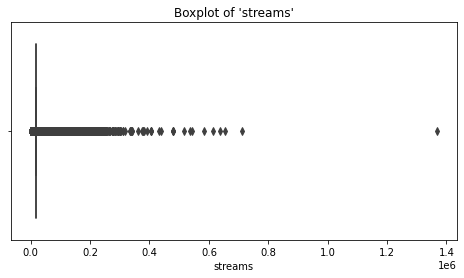

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize


# 2.6.1 Visual Check of Outliers (Boxplot)

if "streams" in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df["streams"])
    plt.title("Boxplot of 'streams'")
    plt.show()

# 2.6.2 Winsorization
# If we want to reduce extreme outliers in "streams" by capping bottom 5% and top 5%:
if "streams" in df.columns:
    df["streams"] = winsorize(df["streams"], limits=[0.05, 0.05])

# 2.6.3 Alternative: Capping at a specific percentile
# Capping website_visits at the 99th percentile
if "website_visits" in df.columns:
    cap_99 = df["website_visits"].quantile(0.99)
    df["website_visits"] = np.where(
        df["website_visits"] > cap_99, cap_99, df["website_visits"]
    )


## Step 4: Data Preprocessing and Feature Engineering

### 4.1 Normalize/standardize numerical variables

In [13]:
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Identify numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns

# Box-Cox for skewed numeric columns

skewed_cols = ["annual_income", "purchase_amount_total"]

for col in skewed_cols:
    if col in df.columns:
        # Ensure positivity for Box-Cox
        min_val = df[col].min()
        if min_val <= 0:
            df[col] = df[col] + abs(min_val) + 1
        # Apply Box-Cox
        transformed, lam = boxcox(df[col])
        df[col + "_boxcox"] = transformed
        print(f"Applied Box-Cox on {col} (lambda: {lam:.4f}).")
        # Optionally drop the original column
        # df.drop(columns=[col], inplace=True)

# StandardScaler
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# MinMaxScaler to [0,1]
minmax = MinMaxScaler()
df[num_cols] = minmax.fit_transform(df[num_cols])

### 4.2 Encode categorical variables

In [22]:
# Identify columns of object dtype
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("\nCategorical columns (initial):", cat_cols)

# Exclude columns that are not suitable for one-hot:

exclude_cols = ["track_id", "genres", "available_markets", "added_at", "name"]
cat_cols = [c for c in cat_cols if c not in exclude_cols]
print("Final cat columns to encode:", cat_cols)

# Collapse rare categories in "occupation" or other columns
if "occupation" in df.columns:
    freq_table = df["occupation"].value_counts()
    threshold = 0.05 * len(df)
    rare_cats = freq_table[freq_table < threshold].index
    df["occupation"] = df["occupation"].replace(rare_cats, "Other")

# One-hot encode only the columns we kept
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("\nShape after one-hot encoding:", df_encoded.shape)


Categorical columns (initial): ['track_id', 'genres', 'chart', 'added_at', 'available_markets', 'name']
Final cat columns to encode: ['chart']

Shape after one-hot encoding: (899702, 36)


### 4.3 Create meaningful new features

In [23]:
import re

# 4.3.1 Artist Network Features
# Calculate artist prominence metrics
artist_metrics = df_encoded.groupby("track_artists").agg(
    artist_stream_avg=("streams", "mean"),
).reset_index()

# Merge artist context features
df_encoded = df_encoded.merge(artist_metrics, on="track_artists", how="left")

# 4.3.2 Genre Features
df["genre_count"] = df["genres"].apply(len)

# 4.3.3 Audio Profile Features
# Create interaction terms between audio features
df_encoded["energy_dance_ratio"] = df_encoded["energy"] / (df_encoded["danceability"] + 1e-6)

# 4.3.4 Market Penetration Features
# Calculate market coverage metrics
df_encoded["market_coverage"] = df_encoded["available_markets"].apply(len)
df_encoded["top_20_market"] = df_encoded["market_coverage"].apply(lambda x: 1 if x >= 20 else 0)

# 4.3.5 Track Version Features
# Detect special track versions using naming patterns
version_patterns = r"(remix|live|version|acoustic|edit|radio)"
df_encoded["is_special_version"] = df_encoded["name"].str.contains(version_patterns, flags=re.IGNORECASE).astype(int)

# 4.3.6 Trend Response Features
# Encode trend dynamics
df_encoded["is_new_entry"] = (df_encoded["trend"] == "NEW_ENTRY").astype(int)

# 4.3.7 Collaboration Features
df_encoded["is_collaboration"] = df_encoded["track_artists"].apply(lambda x: 1 if ", " in str(x) else 0)

c:\Users\86187\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


### 4.4 Final Data Checks

In [25]:
# 4.4.1 Check for Missing Values
print("\n=== Missing Values After Transformations & Encoding ===")
print(df_encoded.isnull().sum().sort_values(ascending=False))

# 4.4.2 Check Data Types
print("\n=== Data Types of Encoded DataFrame ===")
print(df_encoded.dtypes)

# 4.4.3 Data Shape and Sample
print("\nData Shape (rows, columns):", df_encoded.shape)

print("\n=== Sample Rows of Encoded Data ===")
display(df_encoded.head(10))


=== Missing Values After Transformations & Encoding ===
track_id               0
album_release_year     0
danceability           0
valence                0
acousticness           0
liveness               0
trend                  0
instrumentalness       0
loudness               0
name                   0
album_release_month    0
speechiness            0
chart_unknown          0
chart_viral50          0
artist_stream_avg      0
energy_dance_ratio     0
market_coverage        0
top_20_market          0
is_special_version     0
is_new_entry           0
region                 0
album_name             0
streams                0
energy                 0
artist_followers       0
genres                 0
album_total_tracks     0
track_artists          0
artist_popularity      0
explicit               0
tempo                  0
album_release_date     0
key                    0
time_signature         0
added_at               0
popularity             0
track_album_album      0
duration_ms       

,track_id,streams,artist_followers,genres,album_total_tracks,track_artists,artist_popularity,explicit,tempo,album_release_date,...,album_release_month,chart_unknown,chart_viral50,artist_stream_avg,energy_dance_ratio,market_coverage,top_20_market,is_special_version,is_new_entry,is_collaboration
0,07vS8obfeZbr8H4MgQfXR7,0.0,0.020559,"[indie pop, la indie, pov: indie]",0.001001,Phoebe Bridgers,0.74,False,0.388673,2018-12-05,...,12,1,0,0.0,0.328109,0,0,0,0,0
1,1PEqh7awkpuepLBSq8ZwqD,0.0,0.000746,"[lilith, new wave pop]",0.010010,unknown,0.51,False,0.415260,1996-04-16,...,4,0,0,0.0,0.605826,184,1,0,1,0
2,7E8pPgBY84oDaXRcqODavR,0.0,0.000520,"[deep groove house, house, tech house]",0.001001,unknown,0.54,False,0.488317,2014-07-07,...,7,1,0,0.0,1.169490,0,0,1,0,0
3,0Atml4huw4Fgyk6YSHiK4M,0.0,0.000013,[],0.014014,unknown,0.00,False,0.336532,2001-01-24,...,1,1,0,0.0,0.797317,0,0,0,0,0
4,4WYDmIZrwxBHdBYdvi5oQO,0.0,0.000060,"[chill lounge, deep chill]",0.025025,unknown,0.28,False,0.624320,2014-10-03,...,10,1,0,0.0,0.584447,185,1,0,0,0
5,0awG4a7t5UrmZZ4PZVNav3,0.0,0.000250,[post-disco],0.028028,Oliver Cheatham,0.50,False,0.466368,2020-05-08,...,5,1,0,0.0,0.702826,0,0,0,0,0
6,1DihsSBztAD6qJ5TTEE90F,0.0,0.003124,"[classic italian pop, italian adult pop]",0.010010,unknown,0.44,False,0.480242,2015-02-12,...,2,1,0,0.0,0.883358,0,0,0,0,0
7,2uwnP6tZVVmTovzX5ELooy,0.0,0.205030,"[conscious hip hop, hip hop, north carolina hi...",0.020020,unknown,0.84,True,0.400130,2013-06-18,...,6,1,0,0.0,0.906985,184,1,0,0,0
8,05HYPQPzZXyvirt2Gsbvut,0.0,0.019045,"[classic country pop, classic texas country, c...",0.010010,Willie Nelson,0.69,False,0.324019,2016-02-26,...,2,1,0,0.0,0.390442,185,1,0,0,0
9,3FUPP0Q5E2JKopEUHXIwdw,0.0,0.000002,[],0.002002,unknown,0.31,False,0.356968,2023-01-08,...,1,1,0,0.0,0.351176,185,1,0,0,0
